## Off Policy Monte Carlo Control example of Maze

In [1]:
USE {
    repositories {
        mavenCentral()
        maven("https://central.sonatype.com/repository/maven-snapshots/")
    }
    dependencies {
        implementation("io.github.kotlinrl:integration:0.1.0-SNAPSHOT")
        implementation("io.github.kotlinrl:tabular:0.1.0-SNAPSHOT")
        implementation("io.github.kotlinrl:envs:0.1.0-SNAPSHOT")
        implementation("io.github.kotlinrl:rendering:0.1.0-SNAPSHOT")
    }
}

In [2]:
import io.github.kotlinrl.core.*
import io.github.kotlinrl.core.RecordVideo
import io.github.kotlinrl.core.api.*
import io.github.kotlinrl.core.wrapper.*
import io.github.kotlinrl.envs.*
import io.github.kotlinrl.rendering.*
import io.github.kotlinrl.tabular.*
import io.github.kotlinrl.tabular.mc.*
import org.jetbrains.kotlinx.kandy.letsplot.export.*
import org.jetbrains.kotlinx.multik.api.*
import org.jetbrains.kotlinx.multik.api.io.*
import org.jetbrains.kotlinx.multik.ndarray.data.*
import org.jetbrains.kotlinx.multik.ndarray.operations.max
import java.io.*


Let's define our hyper-parameters to control training and learning

In [3]:
val maxStepsPerEpisode = 4_500
val trainingEpisodes = 1_000
val testEpisodes = 30
val initialEpsilon = 0.99
val linearDecayRate = 0.001
val minEpsilon = 0.0
val gamma = 0.99
val fileName = "MazeOffPolicyMonteCarloControl.npy"


Creating the following
- Maze = ```TabularEnv```
        - LEFT = 3
- The Target Policy as a ```PTable``` - this is the policy improved by the algorithm
- The ```QTable``` used to capture training information
    - Monte Carlo Control must wait until the end of each Episode to update the ```QTable```
values.
    - We prime the QTable with negative rewards except the goal to help with convergence in training.

In [4]:
val env = Maze(render = true)
val recordEnv = RecordVideo(env = env, folder = "./videos/maze_off_policy_mcc", 10)

val policy = mk.d1array(25) { 0 }
val trainingQtable: QTable = mk.d2array(25, 4) { -10.0 }
(0 until trainingQtable.shape[1]).forEach { trainingQtable[24, it] = 0.0 }
val (epsilonSchedule, epsilonDecay) = ParameterSchedule.linearDecay(
    initialValue = initialEpsilon,
    minValue = minEpsilon,
    decayRate = linearDecayRate,
    callback = { episode, parameter ->
        if (episode % 100 == 0) {
            println("Episode: $episode, Epsilon: $parameter")
        }
    }
)

Next we create the ```EpisodicTrainer``` using the
- ```Maze``` as the env
- ```LearningAgent``` configure with the ```OffPolicyMonteCarloControl``` algorithm
    - uses the policy ```policy``` as the initial target policy
    - uses the training ```QTable```.
    - a configured epsilon parameter schedule
    - the configured gamma
    - first visit only
- the defined max steps per episode

In [5]:
val trainer = episodicTrainer(
    env = env,
    agent = learningAgent(
        id = "training",
        algorithm = OffPolicyMonteCarloControl(
            initialTargetPolicy = policy,
            epsilon = epsilonSchedule,
            Q = trainingQtable,
            gamma = gamma,
            firstVisitOnly = true,
        ),
    ),
    maxStepsPerEpisode = maxStepsPerEpisode,
    successfulTermination = { it.done },
    callbacks = listOf(
        printEpisodeStart(10),
        onEpisodeEnd { epsilonDecay() }
    )
)
println("Starting training")
val training = trainer.train(maxEpisodes(trainingEpisodes))
mk.writeNPY(fileName, trainingQtable)

Starting training
Starting episode 10
Starting episode 20
Starting episode 30
Starting episode 40
Starting episode 50
Starting episode 60
Starting episode 70
Starting episode 80
Starting episode 90
Starting episode 100
Episode: 100, Epsilon: Parameter(current=0.8899999999999999, previous=0.8909999999999999, minValue=0.0)
Starting episode 110
Starting episode 120
Starting episode 130
Starting episode 140
Starting episode 150
Starting episode 160
Starting episode 170
Starting episode 180
Starting episode 190
Starting episode 200
Episode: 200, Epsilon: Parameter(current=0.7899999999999998, previous=0.7909999999999998, minValue=0.0)
Starting episode 210
Starting episode 220
Starting episode 230
Starting episode 240
Starting episode 250
Starting episode 260
Starting episode 270
Starting episode 280
Starting episode 290
Starting episode 300
Episode: 300, Epsilon: Parameter(current=0.6899999999999997, previous=0.6909999999999997, minValue=0.0)
Starting episode 310
Starting episode 320
Startin

Once training is complete, we create the following
- A new ```QTable``` with the same shape, and load the training data
- A new test ```Agent``` using a ```GreedyPolicy``` against the ```QTable``` with loaded weights
- The Greedy Policy always chooses the best action from the ```QTable```
    - It performs the best action given the state: ```(playerSum, dealerSum, usableAce)```

We then test for the number of testing episodes to compare the episode results (i.e. the average reward achieved)

In [6]:
val testingQtable = mk.readNPY<Double, D2>(fileName).asD2Array()

In [7]:
val tester = episodicTrainer(
    env = recordEnv,
    agent = policyAgent(
        id = "testing",
        policy = policy.pi()
    ),
    maxStepsPerEpisode = maxStepsPerEpisode,
    successfulTermination = { it.reward == 0.0 },
    callbacks = listOf(
        printEpisodeStart(10)
    )
)
println("Starting testing")
val test = tester.train(maxEpisodes(testEpisodes))


Starting testing
Starting episode 10
Starting episode 20
Starting episode 30
Max episodes reached: 30


Compare the average results.

In [8]:
println("Training average reward: ${training.totalAverageReward}")
println("Test average reward: ${test.totalAverageReward}")

val vTable = mk.d1array(25) { testingQtable[it].max() ?: 0.0 }

println("QTable")
printQTable(
    testingQtable, rows = 5, columns = 5, actionSymbols = mapOf(
        0 to "↑", 1 to "→", 2 to "↓", 3 to "←"
    )
)
println("Target Policy")
printPolicyGrid(
    policy, 5, 5, mapOf(
        0 to "↑", 1 to "→", 2 to "↓", 3 to "←"
    )
)
displayVideos(recordEnv.folder)


Training average reward: -109.078
Test average reward: -10.0
QTable
Action Value Function:
 -9.56 -10.00 -10.00 -10.00 -10.00 
 -8.65 -10.00 -10.00 -10.00 -10.00 
 -7.73 -10.00 -10.00 -10.00 -10.00 
 -6.79 -10.00  -2.97  -1.99  -1.00 
 -5.85  -4.90  -3.94  -1.00   0.00 
Policy Table:
  ↓   ↑   ↑   ↑   ↑ 
  ↓   ↑   ↑   ↑   ↑ 
  ↓   ↑   ↑   ↑   ↑ 
  ↓   ↑   →   →   ↓ 
  →   →   ↑   →   ↑ 
Target Policy
↓ ↑ ↑ ↑ ↑
↓ ↑ ↑ ↑ ↑
↓ ↑ ↑ ↑ ↑
↓ ↑ → → ↓
→ → ↑ → ↑


## Let's plot our results

The Action Value Function and Policy derived from the behavioral ```QTable```

In [9]:
plotPolicyActionValueGrid(
    testingQtable, 5, 5, mapOf(
        0 to "↑", 1 to "→", 2 to "↓", 3 to "←"
    )
)


<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.5.1/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="rzciCh"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 
 (function() {
 // ----------
 
 var plotSpec={
"layout":{
"name":"grid",
"ncol":2,
"nrow":1,
"fit":true,
"align":false
},
"figures":[{
"ggtitle":{
"text":"Action Value Function"
},
"mapping":{
},
"data":{
"x":[0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0],
"y":[0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-4.0,-4.0,-4.0,-4.0],
"label":["-9.56","-10.0","-10.0","-10.0","-10.0","-8.65","-10.0","-10.0","-10.0","-10.0","-7.73","-10.0","-10.0","-10.0","-10.0","-6.79","-10.0","-2.97","-1.99","-1.0","-5.85","-4.9","-3.94","-1.0","0.0"],
"value":[-9.56,-10.0,-10.0,-10.0,-10.0,-8.65,-10.0,-10.0,-10.0,-10.0,-7.73,-10.0,-10.0,-10.0,-10.0,-6.79,-10.0,-2.97,-1.99,-1.0,-5.85,-4.9,-3.94,-1.0,0.0]
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"fill",
"scale_mapper_kind":"color_gradient",
"high":"#ffffff",
"low":"#5470c6",
"limits":[null,null]
},{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"x",
"name":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"name":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"x",
"y":"y",
"fill":"value"
},
"stat":"identity",
"size":0.5,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"tile",
"data":{
}
},{
"mapping":{
"x":"x",
"y":"y",
"label":"label"
},
"stat":"identity",
"size":6.0,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"text",
"data":{
}
}],
"data_meta":{
"series_annotations":[{
"type":"int",
"column":"x"
},{
"type":"int",
"column":"y"
},{
"type":"float",
"column":"value"
},{
"type":"str",
"column":"label"
}]
},
"spec_id":"3"
},{
"ggtitle":{
"text":"Policy"
},
"mapping":{
},
"data":{
"x":[0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0],
"y":[0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-4.0,-4.0,-4.0,-4.0],
"label":["↓","↑","↑","↑","↑","↓","↑","↑","↑","↑","↓","↑","↑","↑","↑","↓","↑","→","→","↓","→","→","↑","→","↑"],
"value":[-9.56,-10.0,-10.0,-10.0,-10.0,-8.65,-10.0,-10.0,-10.0,-10.0,-7.73,-10.0,-10.0,-10.0,-10.0,-6.79,-10.0,-2.97,-1.99,-1.0,-5.85,-4.9,-3.94,-1.0,0.0]
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"fill",
"scale_mapper_kind":"color_gradient",
"high":"#ffffff",
"low":"#5470c6",
"limits":[null,null]
},{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"x",
"name":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"name":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"x",
"y":"y",
"fill":"value"
},
"stat":"identity",
"size":0.5,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"tile",
"data":{
}
},{
"mapping":{
"x":"x",
"y":"y",
"label":"label"
},
"stat":"identity",
"size":18.0,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"text",
"data":{
}
}],
"data_meta":{
"series_annotations":[{
"type":"int",
"column":"x"
},{
"type":"int",
"column":"y"
},{
"type":"float",
"column":"value"
},{
"type":"str",
"column":"label"
}]
},
"spec_id":"4"
}],
"kind":"subplots"
};
 var containerDiv = document.getElementById("rzciCh");
 
 var toolbar = null;
 var plotContainer = containerDiv; 
 
 var options = {
 sizing: {
 width_mode: "fixed",
 height_mode: "fixed",
 width: 600.0,
 height: 400.0
 }
 };
 var f

The State Value Function and Policy derived from the target policy ```PTable```

In [10]:
plotPolicyStateValueGrid(
    policy, vTable, 5, 5, mapOf(
        0 to "↑", 1 to "→", 2 to "↓", 3 to "←"
    )
)


<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.5.1/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="OGilm3"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 
 (function() {
 // ----------
 
 var plotSpec={
"layout":{
"name":"grid",
"ncol":2,
"nrow":1,
"fit":true,
"align":false
},
"figures":[{
"ggtitle":{
"text":"State Value Function"
},
"mapping":{
},
"data":{
"x":[0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0],
"y":[0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-4.0,-4.0,-4.0,-4.0],
"label":["-9.56","-10.0","-10.0","-10.0","-10.0","-8.65","-10.0","-10.0","-10.0","-10.0","-7.73","-10.0","-10.0","-10.0","-10.0","-6.79","-10.0","-2.97","-1.99","-1.0","-5.85","-4.9","-3.94","-1.0","0.0"],
"value":[-9.56,-10.0,-10.0,-10.0,-10.0,-8.65,-10.0,-10.0,-10.0,-10.0,-7.73,-10.0,-10.0,-10.0,-10.0,-6.79,-10.0,-2.97,-1.99,-1.0,-5.85,-4.9,-3.94,-1.0,0.0]
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"fill",
"scale_mapper_kind":"color_gradient",
"high":"#ffffff",
"low":"#5470c6",
"limits":[null,null]
},{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"x",
"name":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"name":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"x",
"y":"y",
"fill":"value"
},
"stat":"identity",
"size":0.5,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"tile",
"data":{
}
},{
"mapping":{
"x":"x",
"y":"y",
"label":"label"
},
"stat":"identity",
"size":6.0,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"text",
"data":{
}
}],
"data_meta":{
"series_annotations":[{
"type":"int",
"column":"x"
},{
"type":"int",
"column":"y"
},{
"type":"float",
"column":"value"
},{
"type":"str",
"column":"label"
}]
},
"spec_id":"9"
},{
"ggtitle":{
"text":"Policy"
},
"mapping":{
},
"data":{
"x":[0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0],
"y":[0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-4.0,-4.0,-4.0,-4.0],
"label":["↓","↑","↑","↑","↑","↓","↑","↑","↑","↑","↓","↑","↑","↑","↑","↓","↑","→","→","↓","→","→","↑","→","↑"],
"value":[-9.56,-10.0,-10.0,-10.0,-10.0,-8.65,-10.0,-10.0,-10.0,-10.0,-7.73,-10.0,-10.0,-10.0,-10.0,-6.79,-10.0,-2.97,-1.99,-1.0,-5.85,-4.9,-3.94,-1.0,0.0]
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"fill",
"scale_mapper_kind":"color_gradient",
"high":"#ffffff",
"low":"#5470c6",
"limits":[null,null]
},{
"aesthetic":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"limits":[null,null]
},{
"aesthetic":"x",
"name":"x",
"limits":[null,null]
},{
"aesthetic":"y",
"name":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"x",
"y":"y",
"fill":"value"
},
"stat":"identity",
"size":0.5,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"tile",
"data":{
}
},{
"mapping":{
"x":"x",
"y":"y",
"label":"label"
},
"stat":"identity",
"size":18.0,
"color":"#000000",
"sampling":"none",
"inherit_aes":false,
"position":"identity",
"geom":"text",
"data":{
}
}],
"data_meta":{
"series_annotations":[{
"type":"int",
"column":"x"
},{
"type":"int",
"column":"y"
},{
"type":"float",
"column":"value"
},{
"type":"str",
"column":"label"
}]
},
"spec_id":"10"
}],
"kind":"subplots"
};
 var containerDiv = document.getElementById("OGilm3");
 
 var toolbar = null;
 var plotContainer = containerDiv; 
 
 var options = {
 sizing: {
 width_mode: "fixed",
 height_mode: "fixed",
 width: 600.0,
 height: 400.0
 }
 };
 var f

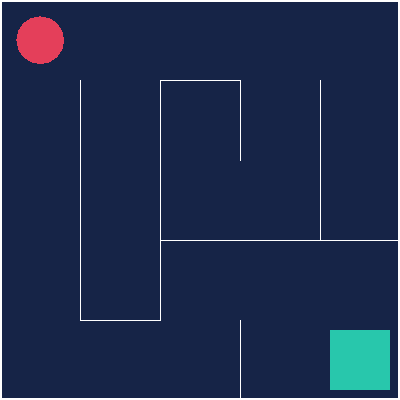

In [11]:
import java.io.File
import javax.imageio.ImageIO
import java.awt.image.BufferedImage

val pngFile = File(recordEnv.folder).listFiles()?.sorted()?.first()?.listFiles()?.sorted()?.first()

val image: BufferedImage = ImageIO.read(pngFile)
image